In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
class myDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        point = self.X[idx]
        point = torch.from_numpy(np.asarray(point))
        point = point.to(torch.float32)
        point = torch.reshape(point, (-1,))
        
        label = self.y[idx]
        label = torch.from_numpy(np.asarray(label))
        label = label.to(torch.float32)
        label = torch.reshape(label, (-1,))
        
        return point, label

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_neurons, feature_size):
        super().__init__()
        self.n = hidden_neurons
        
        self.linear = nn.Sequential(
            nn.Linear(feature_size, self.n),
            nn.ReLU(),
            nn.Linear(self.n, 1)
        )
        
    def forward(self, x):
        return self.linear(x)

In [5]:
def data_loader(sample_size, feature_size):
    X, y = make_regression(n_samples=sample_size, n_features=feature_size, bias=0, noise=10, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    torch.manual_seed(42)

    train_dataset = myDataSet(X_train, y_train)
    test_dataset = myDataSet(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)
    
    return (train_loader, test_loader)

In [6]:
import random

def data_loader_2(sample_size, feature_size):
    X_list = []
    y_list = []
    y_list_2 = []

    for i in range(sample_size):
        x = i / 10 - sample_size / 20
        X_list.append(x)
        rd = 0
        if (random.random() <= 0.3):
            rd = 60 * random.random()
        elif (0.3 < random.random() <= 0.6):
            rd = - 60 * random.random()

        y_list.append(x**3 - 2*x**2 + 4*x + rd)
        y_list_2.append(x**3 - 2*x**2 + 4*x)
        
    plt.xlabel("X")
    plt.ylabel("y")
    plt.plot(X_list, y_list)
    plt.show()
        
    X = np.expand_dims(X_list, -1)
    y = np.expand_dims(y_list, -1)
    y_2 = np.expand_dims(y_list_2, -1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

    train_dataset = myDataSet(X_train, y_train)
    test_dataset = myDataSet(X_test, y_test)

    #train_dataset = myDataSet(X, y)
    #test_dataset = myDataSet(X, y_2)

    train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)
    
    return (train_loader, test_loader)

In [7]:
import sys

def train_model(train_loader, test_loader, neuron_size, feature_size):
    loss_fn = nn.MSELoss()
    mlp = MLP(hidden_neurons=neuron_size, feature_size=feature_size)
    mlp = mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-5)
    
    last_train_loss = sys.maxsize
    current_train_loss = sys.maxsize - 10
    
    while last_train_loss - current_train_loss > 1:
        #print("Train Loss : ", current_train_loss)
        
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_hat = mlp(x)
            loss = loss_fn(y, y_hat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        last_train_loss, current_train_loss = current_train_loss, 0
        
        with torch.no_grad():
            mlp.eval()
            for data in train_loader:
                inputs, outputs = data
                inputs = inputs.to(device)
                outputs = outputs.to(device)
                predicted_outputs = mlp(inputs)
                loss = loss_fn(predicted_outputs, outputs)
                current_train_loss += loss
        
        current_train_loss /= len(train_loader)
        
        
    total_test_loss = 0
    with torch.no_grad():
        mlp.eval()
        for data in test_loader:
            inputs, outputs = data
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            predicted_outputs = mlp(inputs)
            loss = loss_fn(predicted_outputs, outputs)
            total_test_loss += loss
    total_test_loss = total_test_loss / len(test_loader)

    return total_test_loss.detach().cpu().squeeze().numpy()

In [8]:
def train_model_fix(train_loader, test_loader, neuron_size, feature_size):
    loss_fn = nn.MSELoss()
    mlp = MLP(hidden_neurons=neuron_size, feature_size=feature_size)
    mlp = mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-5)
    epoch = 20
    
    for i in range(epoch):
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_hat = mlp(x)
            loss = loss_fn(y, y_hat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    total_test_loss = 0
    with torch.no_grad():
        mlp.eval()
        for data in test_loader:
            inputs, outputs = data
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            predicted_outputs = mlp(inputs)
            loss = loss_fn(predicted_outputs, outputs)
            total_test_loss += loss
    total_test_loss = total_test_loss / len(test_loader)

    return total_test_loss.detach().cpu().squeeze().numpy()

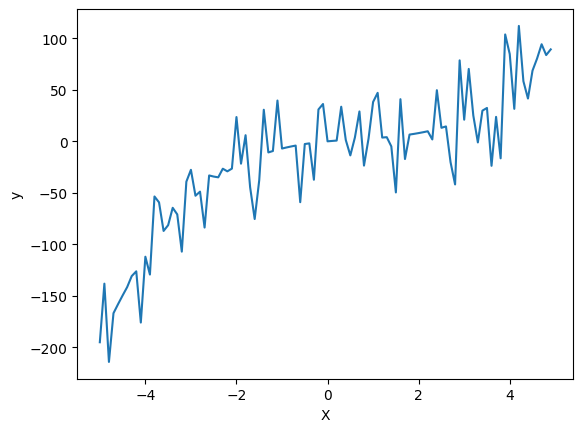

Neuron Size :  1  ; Test Loss :  4133.2305
Neuron Size :  2  ; Test Loss :  1439.8806
Neuron Size :  3  ; Test Loss :  1468.0215
Neuron Size :  4  ; Test Loss :  1906.0066
Neuron Size :  5  ; Test Loss :  1444.0284
Neuron Size :  6  ; Test Loss :  1441.5558
Neuron Size :  7  ; Test Loss :  1396.2838
Neuron Size :  8  ; Test Loss :  1387.0199
Neuron Size :  9  ; Test Loss :  1413.6862
Neuron Size :  10  ; Test Loss :  1434.9763
Neuron Size :  11  ; Test Loss :  1395.2719
Neuron Size :  12  ; Test Loss :  1364.3705
Neuron Size :  13  ; Test Loss :  1395.0103
Neuron Size :  14  ; Test Loss :  1389.9397
Neuron Size :  15  ; Test Loss :  1382.3977
Neuron Size :  16  ; Test Loss :  1353.6414
Neuron Size :  17  ; Test Loss :  1410.3477
Neuron Size :  18  ; Test Loss :  1396.5533
Neuron Size :  19  ; Test Loss :  1383.4196
Neuron Size :  20  ; Test Loss :  1384.4995
Neuron Size :  21  ; Test Loss :  1379.137
Neuron Size :  22  ; Test Loss :  1367.9733
Neuron Size :  23  ; Test Loss :  1359.455

Neuron Size :  186  ; Test Loss :  1276.3109
Neuron Size :  187  ; Test Loss :  1265.7749
Neuron Size :  188  ; Test Loss :  1269.6718
Neuron Size :  189  ; Test Loss :  1248.2102
Neuron Size :  190  ; Test Loss :  1261.861
Neuron Size :  191  ; Test Loss :  1265.0493
Neuron Size :  192  ; Test Loss :  1240.0931
Neuron Size :  193  ; Test Loss :  1247.3768
Neuron Size :  194  ; Test Loss :  1265.6893
Neuron Size :  195  ; Test Loss :  1282.2407
Neuron Size :  196  ; Test Loss :  1238.414
Neuron Size :  197  ; Test Loss :  1266.7689
Neuron Size :  198  ; Test Loss :  1243.8914
Neuron Size :  199  ; Test Loss :  1236.126


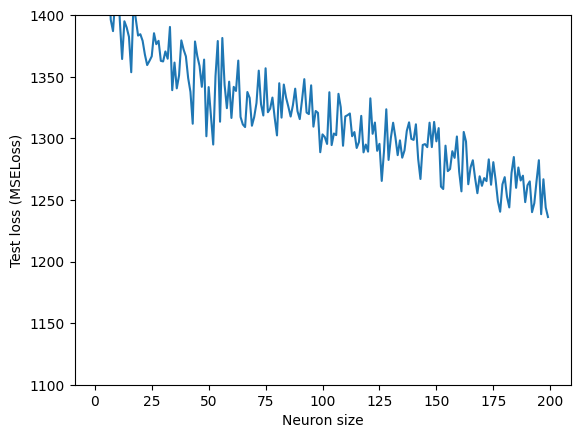

In [9]:
losses = []
n_neurons = [i for i in range(1, 200, 1)]
train_loader, test_loader = data_loader_2(100, 1)

for n in n_neurons:
    l = train_model(train_loader, test_loader, n, 1)
    print("Neuron Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Neuron size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_neurons, losses)
plt.ylim([1100, 1400])
plt.show()

(70, 50) (70,)
(30, 50) (30,)
Sample Size :  100  ; Test Loss :  6157.0723
(73, 50) (73,)
(32, 50) (32,)
Sample Size :  105  ; Test Loss :  3830.475
(77, 50) (77,)
(33, 50) (33,)
Sample Size :  110  ; Test Loss :  9425.436
(80, 50) (80,)
(35, 50) (35,)
Sample Size :  115  ; Test Loss :  4991.452
(84, 50) (84,)
(36, 50) (36,)
Sample Size :  120  ; Test Loss :  2895.1787
(87, 50) (87,)
(38, 50) (38,)
Sample Size :  125  ; Test Loss :  6171.958
(91, 50) (91,)
(39, 50) (39,)
Sample Size :  130  ; Test Loss :  6224.6733
(94, 50) (94,)
(41, 50) (41,)
Sample Size :  135  ; Test Loss :  4719.692
(98, 50) (98,)
(42, 50) (42,)
Sample Size :  140  ; Test Loss :  6109.144
(101, 50) (101,)
(44, 50) (44,)
Sample Size :  145  ; Test Loss :  4162.9106
(105, 50) (105,)
(45, 50) (45,)
Sample Size :  150  ; Test Loss :  3325.7559
(108, 50) (108,)
(47, 50) (47,)
Sample Size :  155  ; Test Loss :  3844.618
(112, 50) (112,)
(48, 50) (48,)
Sample Size :  160  ; Test Loss :  3939.0881
(115, 50) (115,)
(50, 50

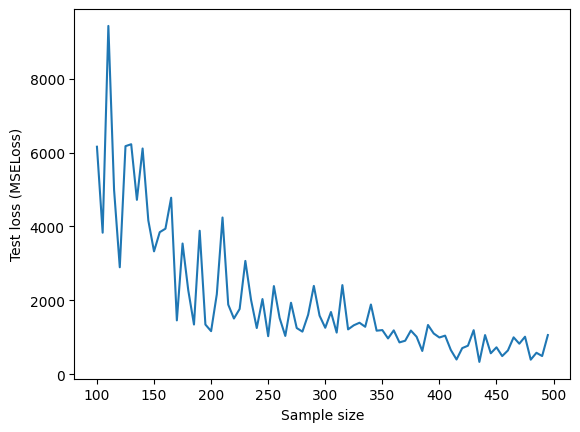

In [10]:
losses = []
#n_neurons = [i for i in range(5, 400, 5)]
n_sample = [i for i in range(100, 500, 5)]

for n in n_sample:
    train_loader, test_loader = data_loader(sample_size=n, feature_size=50)
    l = train_model(train_loader, test_loader, neuron_size=10, feature_size=50)
    print("Sample Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Sample size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_sample, losses)
plt.show()

(70, 1) (70,)
(30, 1) (30,)
Feature Size :  1  ; Test Loss :  116.4912
(70, 11) (70,)
(30, 11) (30,)
Feature Size :  11  ; Test Loss :  720.8673
(70, 21) (70,)
(30, 21) (30,)
Feature Size :  21  ; Test Loss :  968.20215
(70, 31) (70,)
(30, 31) (30,)
Feature Size :  31  ; Test Loss :  3745.378
(70, 41) (70,)
(30, 41) (30,)
Feature Size :  41  ; Test Loss :  7401.6616
(70, 51) (70,)
(30, 51) (30,)
Feature Size :  51  ; Test Loss :  8980.99
(70, 61) (70,)
(30, 61) (30,)
Feature Size :  61  ; Test Loss :  7860.5747
(70, 71) (70,)
(30, 71) (30,)
Feature Size :  71  ; Test Loss :  5917.838
(70, 81) (70,)
(30, 81) (30,)
Feature Size :  81  ; Test Loss :  17294.666
(70, 91) (70,)
(30, 91) (30,)
Feature Size :  91  ; Test Loss :  20565.94
(70, 101) (70,)
(30, 101) (30,)
Feature Size :  101  ; Test Loss :  26025.066
(70, 111) (70,)
(30, 111) (30,)
Feature Size :  111  ; Test Loss :  14079.365
(70, 121) (70,)
(30, 121) (30,)
Feature Size :  121  ; Test Loss :  17716.045
(70, 131) (70,)
(30, 131) 

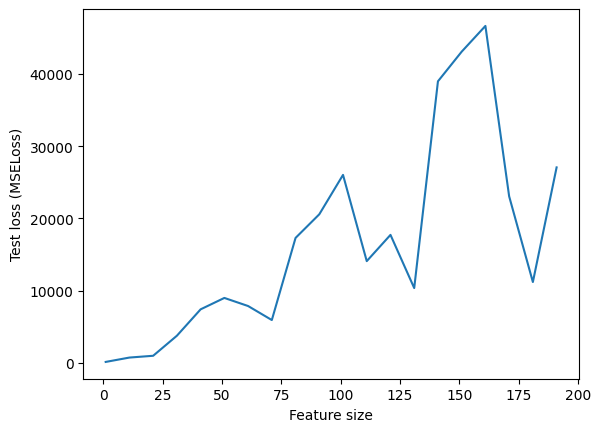

In [11]:
losses = []
n_feature = [i for i in range(1, 200, 10)]

for n in n_feature:
    train_loader, test_loader = data_loader(sample_size=100, feature_size=n)
    l = train_model(train_loader, test_loader, neuron_size=50, feature_size=n)
    print("Feature Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Feature size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_feature, losses)
plt.show()

(2800, 700) (2800,)
(1200, 700) (1200,)
Feature Size :  1  ; Test Loss :  396.3049
Feature Size :  11  ; Test Loss :  1297.3342
Feature Size :  21  ; Test Loss :  1389.4299
Feature Size :  31  ; Test Loss :  1379.5518
Feature Size :  41  ; Test Loss :  1422.5597
Feature Size :  51  ; Test Loss :  1442.4398
Feature Size :  61  ; Test Loss :  1464.9385
Feature Size :  71  ; Test Loss :  1519.8499
Feature Size :  81  ; Test Loss :  1492.9099
Feature Size :  91  ; Test Loss :  1529.6298
Feature Size :  101  ; Test Loss :  1559.5543
Feature Size :  111  ; Test Loss :  1603.0109
Feature Size :  121  ; Test Loss :  1665.6726
Feature Size :  131  ; Test Loss :  1530.0355
Feature Size :  141  ; Test Loss :  1579.888
Feature Size :  151  ; Test Loss :  1650.2568
Feature Size :  161  ; Test Loss :  1661.5919
Feature Size :  171  ; Test Loss :  1639.9833
Feature Size :  181  ; Test Loss :  1673.9781
Feature Size :  191  ; Test Loss :  1688.127


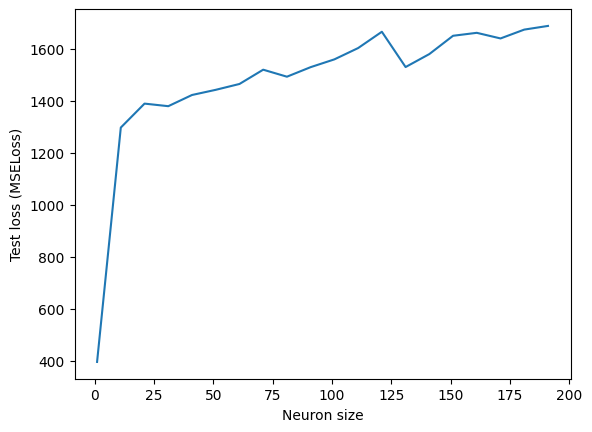

In [12]:
losses = []
n_neurons = [i for i in range(1, 200, 10)]
train_loader, test_loader = data_loader(sample_size=4000, feature_size=700)

for n in n_neurons:
    l = train_model(train_loader, test_loader, neuron_size=n, feature_size=700)
    print("Feature Size : ", n, " ; Test Loss : ", l)
    losses.append(l)
    
plt.xlabel("Neuron size")
plt.ylabel("Test loss (MSELoss)")
plt.plot(n_neurons, losses)
plt.show()